### Initialize library

In [1]:
import sys
import os

# Add the directory containing 'vlm_library.py' and 'sam2' to the Python path
sys.path.append('./osg/segment_anything_2/')

In [2]:
from limp.utils.gen_utils import ltl2dfa, llm4tl, referent_verification, task_structure_verification, get_spatial_referents
from osg.utils.general_utils import load_data, create_observation_graph
from osg.vlm_library import vlm_library
from limp.planner.multi_level_planner import progressive_motion_planner

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


2024-08-01 23:31:23.664954: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-01 23:31:23.682767: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-01 23:31:23.688194: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-08-01 23:31:23.700683: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-08-01 23:31:25.003622: W tensorflow/compiler/tf2

In [3]:
tmp_fldr=f"results/"
vlm_instance = vlm_library(vl_model="owl_vit",  seg_model="mobile_sam", tmp_fldr=tmp_fldr)


Visual language model: owl_vit
-------------------------------------------------
Segmentation model: Mobile SAM
-------------------------------------------------


### Load data

In [4]:
data_path = "./data/sample_data"

observation_data, edge_connectivity, env_pointcloud = load_data(data_path, tmp_fldr)
observations_graph, _, _, _ = create_observation_graph(observation_data,edge_connectivity,tmp_fldr=tmp_fldr)

0 out of 12 || Getting cardinal images for waypoint:balky-cuckoo-DSOhlw+wDw5TKMQhzKNg1Q==
1 out of 12 || Getting cardinal images for waypoint:bended-drum-ZK.nOK2ROH99jbDMGbrG3Q==
2 out of 12 || Getting cardinal images for waypoint:brainy-eel-acD1gEPuOhQgqad45uHuXw==
3 out of 12 || Getting cardinal images for waypoint:frayed-emu-M5JSw0IiYB8xYBwfswR41Q==
4 out of 12 || Getting cardinal images for waypoint:garish-rat-RgSDxBIafXZwgLb2o+h3TA==
5 out of 12 || Getting cardinal images for waypoint:leafy-mayfly-8hSmtSRh9YMd0eyKxJ6Tjw==
6 out of 12 || Getting cardinal images for waypoint:lemony-gibbon-44n7dioWNlkPvLqiIcb2gg==
7 out of 12 || Getting cardinal images for waypoint:lethal-fish-xlr1rhR2yqmfn88mEo7FTw==
8 out of 12 || Getting cardinal images for waypoint:phoney-shark-vJbZmiet4YMbuu.hDi4IOA==
9 out of 12 || Getting cardinal images for waypoint:scared-redbug-AHDnuMg2GzoyJUZUrvMuYA==
10 out of 12 || Getting cardinal images for waypoint:tan-mamba-2DaJ2+ZpP88jbK93.0w4nA==
11 out of 12 || Ge

### Language to  Ltl

In [10]:
#Demo instruction: Bring the green plush toy to the whiteboard in front of it

print(f"\n*************************************************************************\nInstruction Following\n*************************************************************************")
input_lang_instruction = input("Enter the natural language description of the task: ")

in_context_examples = "limp/language/temporal_logic/ltl_datasets/efficient-eng-2-ltl-droneplanning"
in_context_count    = 10
lang2ltl_path       = "limp/language/temporal_logic/embedding_cache/small-droneplanning_lang2ltl.pkl" 
lang2embedding_path = "limp/language/temporal_logic/embedding_cache/small-droneplanning_lang2embeddings.pkl"

print(f'\nInput instruction: "{input_lang_instruction}"')
print("Running Language Instruction Module ...")

strategy_choice="two_stage_similar_embedding"
# strategy_choice="two_stage_random_embedding"
# strategy_choice="single_stage"

encoding_map, response_ltl, spot_ltl, llm_response_history= llm4tl(input_lang_instruction, in_context_examples, lang2embedding_path, lang2ltl_path, in_context_count, enable_prints=False, strategy=strategy_choice)
original_encoding_map, original_response_ltl, original_spot_ltl, original_llm_response_history = encoding_map, response_ltl, spot_ltl, llm_response_history 

print("Spotify predicate encoding map: ", encoding_map)
print("Response LTL formula: ", response_ltl)
print("Cleaned LTL formula: ", spot_ltl,"\n")

display(spot_ltl)


*************************************************************************
Instruction Following
*************************************************************************

Input instruction: "Bring the green plush toy to the whiteboard in front of it"
Running Language Instruction Module ...
		Model: gpt-4 || Deterministic?: False
		Model: gpt-4 || Deterministic?: False
Spotify predicate encoding map:  {'A': 'near[green_plush_toy]', 'B': 'pick[green_plush_toy]', 'C': 'near[whiteboard::isinfrontof(green_plush_toy)]', 'D': 'release[green_plush_toy,whiteboard::isinfrontof(green_plush_toy)]'}
Response LTL formula:  F ( A & F ( B & F ( C & F ( D ) ) ) )
Cleaned LTL formula:  F(A & F(B & F(C & FD))) 



spot.formula("F(A & F(B & F(C & FD)))")

### Interactive Symbol Verification

In [11]:
# Referent verification
encoding_map, response_ltl, spot_ltl, llm_response_history  = referent_verification(input_lang_instruction, encoding_map, response_ltl, spot_ltl, llm_response_history, strategy_choice)

Original instruction:  Bring the green plush toy to the whiteboard in front of it
Last llm ltl response:  F ( near[green_plush_toy] & F ( pick[green_plush_toy] & F ( near[whiteboard::isinfrontof(green_plush_toy)] & F ( release[green_plush_toy,whiteboard::isinfrontof(green_plush_toy)] ) ) ) ) 

*****************************
Referent Verification
*****************************
I extracted this list of relevant objects based on your instruction:
	* green_plush_toy
	* whiteboard::isinfrontof(green_plush_toy)
Does this match your intention? (y/n)


In [12]:
#Task structure verification
encoding_map, response_ltl, spot_ltl, llm_response_history, selected_dfa_path  = task_structure_verification(input_lang_instruction, encoding_map, response_ltl, spot_ltl, llm_response_history, strategy_choice)

Plausible DFA paths to goal:  [[0, 1, 2, 3, 4]] Selected_path:  [0, 1, 2, 3, 4] 

Original instruction:  Bring the green plush toy to the whiteboard in front of it
Last llm ltl response:  F ( near[green_plush_toy] & F ( pick[green_plush_toy] & F ( near[whiteboard::isinfrontof(green_plush_toy)] & F ( release[green_plush_toy,whiteboard::isinfrontof(green_plush_toy)] ) ) ) )
Encoded form:  F(A & F(B & F(C & FD))) 

*****************************
Task Structure Verification
*****************************
Based on my understanding here is the sequence of subgoal objectives needed to satisfy the task:
Subgoal_1:
	 Logical Expression: A&!B
	 Decoded Expression: near[green_plush_toy] & ! pick[green_plush_toy]
	 English translation: I should be near the [green_plush_toy] and not have picked up the [green_plush_toy]
Subgoal_2:
	 Logical Expression: B&!C
	 Decoded Expression: pick[green_plush_toy] & ! near[whiteboard::isinfrontof(green_plush_toy)]
	 English translation: I should have picked up the 

In [13]:
# Visualize original and verified results
print("*****************************************\nOriginal Results\n*****************************************")
print("Original encoded formula: ",original_spot_ltl)
print("Original encoding map: ",original_encoding_map)
print("*****************************************\nAfter Verification\n*****************************************")
print("Verified encoded formula: ",spot_ltl)
print("Verified encoding map: ",encoding_map)

*****************************************
Original Results
*****************************************
Original encoded formula:  F(A & F(B & F(C & FD)))
Original encoding map:  {'A': 'near[green_plush_toy]', 'B': 'pick[green_plush_toy]', 'C': 'near[whiteboard::isinfrontof(green_plush_toy)]', 'D': 'release[green_plush_toy,whiteboard::isinfrontof(green_plush_toy)]'}
*****************************************
After Verification
*****************************************
Verified encoded formula:  F(A & F(B & F(C & FD)))
Verified encoding map:  {'A': 'near[green_plush_toy]', 'B': 'pick[green_plush_toy]', 'C': 'near[whiteboard::isinfrontof(green_plush_toy)]', 'D': 'release[green_plush_toy,whiteboard::isinfrontof(green_plush_toy)]'}


### Construct task dfa from ltl

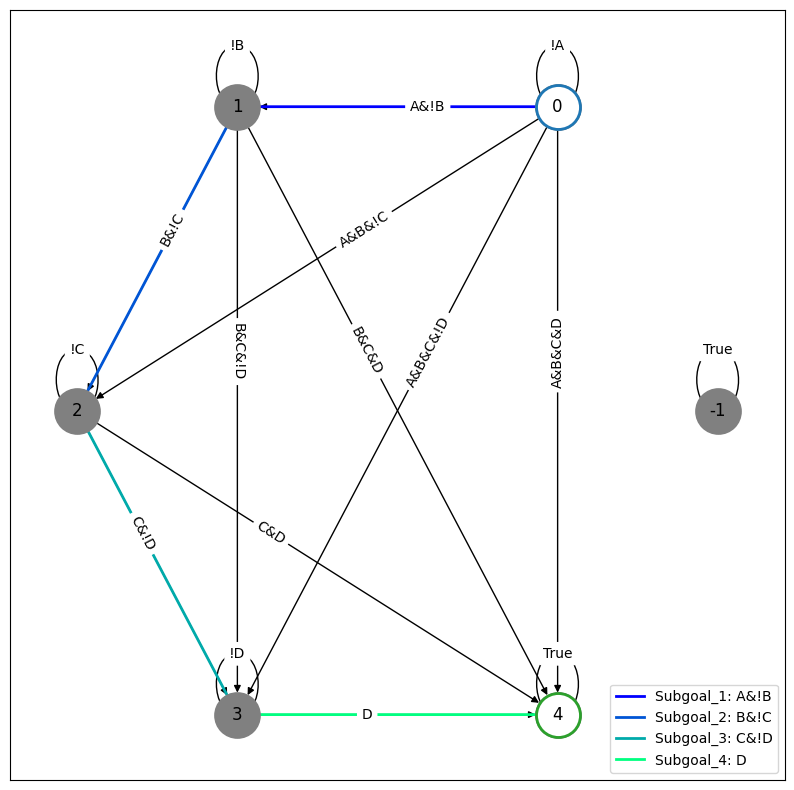

********************************
Task: F(A & F(B & F(C & FD)))
Symbolic maping: {'A': 'near[green_plush_toy]', 'B': 'pick[green_plush_toy]', 'C': 'near[whiteboard::isinfrontof(green_plush_toy)]', 'D': 'release[green_plush_toy,whiteboard::isinfrontof(green_plush_toy)]'}
********************************
Task Dfa Details
********************************
Initial_state    : 0
Accepting_states :[4]
Ltl2state        :{'False': -1, ('until', 'True', ('and', 'A', ('until', 'True', ('and', 'B', ('until', 'True', ('and', 'C', ('until', 'True', 'D'))))))): 0, ('until', 'True', ('and', 'B', ('until', 'True', ('and', 'C', ('until', 'True', 'D'))))): 1, ('until', 'True', ('and', 'C', ('until', 'True', 'D'))): 2, ('until', 'True', 'D'): 3, 'True': 4}
DFA Transitions:
	 Edge: (0, 0, '!A')
	 Edge: (0, 1, 'A&!B')
	 Edge: (0, 2, 'A&B&!C')
	 Edge: (0, 3, 'A&B&C&!D')
	 Edge: (0, 4, 'A&B&C&D')
	 Edge: (1, 1, '!B')
	 Edge: (1, 2, 'B&!C')
	 Edge: (1, 3, 'B&C&!D')
	 Edge: (1, 4, 'B&C&D')
	 Edge: (2, 2, '!C')
	 

In [14]:
#constructing task dfa from ltl formula
task_dfa, dfa_graph = ltl2dfa(encoding_map,spot_ltl, visualize_details=True, show_diagram=True, show_labels=True, path=selected_dfa_path)

### Ground referents and filter instances via spatial constraints

In [15]:
## Extract spatial information
referent_spatial_details = get_spatial_referents(encoding_map)
print("referent_spatial_details: ",referent_spatial_details,"\n")

## Spatial grounding
relevant_element_details = vlm_instance.spatial_grounding(observations_graph, referent_spatial_details, visualize=True, use_segmentation=True, multiprocessing=False, workers=3) #issue with multiprocessing=True (hangs)

print("Referents after spatial constraint filtering:",len(relevant_element_details))
#for all relevant elements print their ids
print(f"\nFiltered elements \n",[element['mask_id'] for element in relevant_element_details])

referent_spatial_details:  {'green_plush_toy': [], 'whiteboard': ['isinfrontof(green_plush_toy)']} 

Propositions to ground: ['green_plush_toy', 'whiteboard']
-------------------------------------------------
Obtaining Relevant Masks
-------------------------------------------------


  0%|          | 0/12 [00:00<?, ?it/s]

Evaluating Waypoint at Node 0
Evaluating Waypoint at Node 0
   Observation_0...
      Detected Task relevant elements: ['whiteboard'] || Segmenting to obtain masks ...
      Loaded depth data from waypoint node 0, observation [0]
      Processing whiteboard mask
         Mask whiteboard_0a_0 || Original Center pixel: (123, 361) || Center pixel depth: 0.0
         Mask whiteboard_0a_0 || Chosen Center pixel: (123, 361) || Average mask depth: 4.623745119305856 || Chosen Mask depth: 4.623745119305856
         Backprojectig 3D ray using pixel: (123, 361) & depth: 4.623745119305856m for whiteboard_0a_0...
         Recording mask info for whiteboard_0a_0...
   Observation_1...
      Detected Task relevant elements: ['whiteboard'] || Segmenting to obtain masks ...
      Loaded depth data from waypoint node 0, observation [1]
      Processing whiteboard mask
         Mask whiteboard_0b_0 || Original Center pixel: (215, 533) || Center pixel depth: 0.0
         Mask whiteboard_0b_0 || Chosen Cen

  8%|▊         | 1/12 [00:05<01:04,  5.89s/it]

Evaluating Waypoint at Node 1
Evaluating Waypoint at Node 1
   Observation_0...
   Observation_1...
   Observation_2...
   Observation_3...
      Detected Task relevant elements: ['whiteboard'] || Segmenting to obtain masks ...
      Loaded depth data from waypoint node 1, observation [3]
      Processing whiteboard mask
         Mask whiteboard_1d_0 || Original Center pixel: (240, 180) || Center pixel depth: 0.0
         Not using depth model, moving on to next mask
      Processing whiteboard mask
         Mask whiteboard_1d_1 || Original Center pixel: (243, 233) || Center pixel depth: 0.0
         Not using depth model, moving on to next mask


 17%|█▋        | 2/12 [00:08<00:42,  4.23s/it]

Evaluating Waypoint at Node 2
Evaluating Waypoint at Node 2
   Observation_0...
      Detected Task relevant elements: ['whiteboard'] || Segmenting to obtain masks ...
      Loaded depth data from waypoint node 2, observation [0]
      Processing whiteboard mask
         Mask whiteboard_2a_0 || Original Center pixel: (161, 464) || Center pixel depth: 2.23
         Mask whiteboard_2a_0 || Chosen Center pixel: (161, 464) || Average mask depth: 2.2719548488942993 || Chosen Mask depth: 2.2719548488942993
         Backprojectig 3D ray using pixel: (161, 464) & depth: 2.2719548488942993m for whiteboard_2a_0...
         Recording mask info for whiteboard_2a_0...
   Observation_1...
   Observation_2...
      Detected Task relevant elements: ['green_plush_toy', 'whiteboard'] || Segmenting to obtain masks ...
      Loaded depth data from waypoint node 2, observation [2]
      Processing whiteboard mask
         Mask whiteboard_2c_0 || Original Center pixel: (215, 322) || Center pixel depth: 0.0


 25%|██▌       | 3/12 [00:12<00:34,  3.80s/it]

Evaluating Waypoint at Node 3
Evaluating Waypoint at Node 3
   Observation_0...
      Detected Task relevant elements: ['whiteboard'] || Segmenting to obtain masks ...
      Loaded depth data from waypoint node 3, observation [0]
      Processing whiteboard mask
         Mask whiteboard_3a_0 || Original Center pixel: (175, 594) || Center pixel depth: 0.0
         Mask whiteboard_3a_0 || Chosen Center pixel: (175, 594) || Average mask depth: 4.5489999999999995 || Chosen Mask depth: 4.5489999999999995
         Backprojectig 3D ray using pixel: (175, 594) & depth: 4.5489999999999995m for whiteboard_3a_0...
         Recording mask info for whiteboard_3a_0...
      Processing whiteboard mask
         Mask whiteboard_3a_1 || Original Center pixel: (208, 60) || Center pixel depth: 0.0
         Mask whiteboard_3a_1 || Chosen Center pixel: (208, 60) || Average mask depth: 4.835399999999999 || Chosen Mask depth: 4.835399999999999
         Backprojectig 3D ray using pixel: (208, 60) & depth: 4.83

 33%|███▎      | 4/12 [00:15<00:29,  3.67s/it]

Evaluating Waypoint at Node 4
Evaluating Waypoint at Node 4
   Observation_0...
   Observation_1...
      Detected Task relevant elements: ['whiteboard'] || Segmenting to obtain masks ...
      Loaded depth data from waypoint node 4, observation [1]
      Processing whiteboard mask
         Mask whiteboard_4b_0 || Original Center pixel: (141, 317) || Center pixel depth: 0.795
         Mask whiteboard_4b_0 || Chosen Center pixel: (141, 317) || Average mask depth: 0.792323281671159 || Chosen Mask depth: 0.792323281671159
         Backprojectig 3D ray using pixel: (141, 317) & depth: 0.792323281671159m for whiteboard_4b_0...
         Recording mask info for whiteboard_4b_0...
      Processing whiteboard mask
         Mask whiteboard_4b_1 || Original Center pixel: (237, 318) || Center pixel depth: 0.773
         Mask whiteboard_4b_1 || Chosen Center pixel: (237, 318) || Average mask depth: 0.7799424552308246 || Chosen Mask depth: 0.7799424552308246
         Backprojectig 3D ray using pixel

 42%|████▏     | 5/12 [00:19<00:24,  3.54s/it]

Evaluating Waypoint at Node 5
Evaluating Waypoint at Node 5
   Observation_0...
   Observation_1...
      Detected Task relevant elements: ['whiteboard'] || Segmenting to obtain masks ...
      Loaded depth data from waypoint node 5, observation [1]
      Processing whiteboard mask
         Mask whiteboard_5b_0 || Original Center pixel: (152, 97) || Center pixel depth: 0.0
         Mask whiteboard_5b_0 || Chosen Center pixel: (152, 97) || Average mask depth: 3.682224628863471 || Chosen Mask depth: 3.682224628863471
         Backprojectig 3D ray using pixel: (152, 97) & depth: 3.682224628863471m for whiteboard_5b_0...
         Recording mask info for whiteboard_5b_0...
   Observation_2...
      Detected Task relevant elements: ['whiteboard'] || Segmenting to obtain masks ...
      Loaded depth data from waypoint node 5, observation [2]
      Processing whiteboard mask
         Mask whiteboard_5c_0 || Original Center pixel: (223, 360) || Center pixel depth: 0.0
         Mask whiteboard_5

 50%|█████     | 6/12 [00:22<00:21,  3.57s/it]

Evaluating Waypoint at Node 6
Evaluating Waypoint at Node 6
   Observation_0...
      Detected Task relevant elements: ['whiteboard'] || Segmenting to obtain masks ...
      Loaded depth data from waypoint node 6, observation [0]
      Processing whiteboard mask
         Mask whiteboard_6a_0 || Original Center pixel: (213, 36) || Center pixel depth: 0.0
         Not using depth model, moving on to next mask
   Observation_1...
   Observation_2...
      Detected Task relevant elements: ['whiteboard'] || Segmenting to obtain masks ...
      Loaded depth data from waypoint node 6, observation [2]
      Processing whiteboard mask
         Mask whiteboard_6c_0 || Original Center pixel: (146, 72) || Center pixel depth: 0.0
         Mask whiteboard_6c_0 || Chosen Center pixel: (146, 72) || Average mask depth: 1.9803355165227747 || Chosen Mask depth: 1.9803355165227747
         Backprojectig 3D ray using pixel: (146, 72) & depth: 1.9803355165227747m for whiteboard_6c_0...
         Recording ma

 58%|█████▊    | 7/12 [00:26<00:17,  3.50s/it]

Evaluating Waypoint at Node 7
Evaluating Waypoint at Node 7
   Observation_0...
      Detected Task relevant elements: ['whiteboard'] || Segmenting to obtain masks ...
      Loaded depth data from waypoint node 7, observation [0]
      Processing whiteboard mask
         Mask whiteboard_7a_0 || Original Center pixel: (228, 203) || Center pixel depth: 0.0
         Mask whiteboard_7a_0 || Chosen Center pixel: (228, 203) || Average mask depth: 5.401999999999999 || Chosen Mask depth: 5.401999999999999
         Backprojectig 3D ray using pixel: (228, 203) & depth: 5.401999999999999m for whiteboard_7a_0...
         Recording mask info for whiteboard_7a_0...
      Processing whiteboard mask
         Mask whiteboard_7a_1 || Original Center pixel: (235, 282) || Center pixel depth: 0.0
         Mask whiteboard_7a_1 || Chosen Center pixel: (235, 282) || Average mask depth: 6.376598901098901 || Chosen Mask depth: 6.376598901098901
         Backprojectig 3D ray using pixel: (235, 282) & depth: 6.37

 67%|██████▋   | 8/12 [00:29<00:13,  3.40s/it]

Evaluating Waypoint at Node 8
Evaluating Waypoint at Node 8
   Observation_0...
   Observation_1...
   Observation_2...
   Observation_3...
      Detected Task relevant elements: ['whiteboard'] || Segmenting to obtain masks ...
      Loaded depth data from waypoint node 8, observation [3]
      Processing whiteboard mask
         Mask whiteboard_8d_0 || Original Center pixel: (246, 544) || Center pixel depth: 0.0
         Not using depth model, moving on to next mask


 75%|███████▌  | 9/12 [00:32<00:10,  3.34s/it]

Evaluating Waypoint at Node 9
Evaluating Waypoint at Node 9
   Observation_0...
      Detected Task relevant elements: ['whiteboard'] || Segmenting to obtain masks ...
      Loaded depth data from waypoint node 9, observation [0]
      Processing whiteboard mask
         Mask whiteboard_9a_0 || Original Center pixel: (154, 135) || Center pixel depth: 3.606
         Mask whiteboard_9a_0 || Chosen Center pixel: (154, 135) || Average mask depth: 3.459508045977012 || Chosen Mask depth: 3.459508045977012
         Backprojectig 3D ray using pixel: (154, 135) & depth: 3.459508045977012m for whiteboard_9a_0...
         Recording mask info for whiteboard_9a_0...
      Processing whiteboard mask
         Mask whiteboard_9a_1 || Original Center pixel: (190, 555) || Center pixel depth: 0.0
         Mask whiteboard_9a_1 || Chosen Center pixel: (190, 555) || Average mask depth: 3.1218120638085742 || Chosen Mask depth: 3.1218120638085742
         Backprojectig 3D ray using pixel: (190, 555) & depth: 

 83%|████████▎ | 10/12 [00:35<00:06,  3.41s/it]

Evaluating Waypoint at Node 10
Evaluating Waypoint at Node 10
   Observation_0...
   Observation_1...
      Detected Task relevant elements: ['whiteboard'] || Segmenting to obtain masks ...
      Loaded depth data from waypoint node 10, observation [1]
      Processing whiteboard mask
         Mask whiteboard_10b_0 || Original Center pixel: (222, 234) || Center pixel depth: 0.0
         Mask whiteboard_10b_0 || Chosen Center pixel: (222, 234) || Average mask depth: 5.026289562289563 || Chosen Mask depth: 5.026289562289563
         Backprojectig 3D ray using pixel: (222, 234) & depth: 5.026289562289563m for whiteboard_10b_0...
         Recording mask info for whiteboard_10b_0...
   Observation_2...
   Observation_3...
      Detected Task relevant elements: ['whiteboard'] || Segmenting to obtain masks ...
      Loaded depth data from waypoint node 10, observation [3]
      Processing whiteboard mask
         Mask whiteboard_10d_0 || Original Center pixel: (204, 438) || Center pixel depth

 92%|█████████▏| 11/12 [00:39<00:03,  3.43s/it]

Evaluating Waypoint at Node 11
Evaluating Waypoint at Node 11
   Observation_0...
      Detected Task relevant elements: ['whiteboard'] || Segmenting to obtain masks ...
      Loaded depth data from waypoint node 11, observation [0]
      Processing whiteboard mask
         Mask whiteboard_11a_0 || Original Center pixel: (233, 556) || Center pixel depth: 0.0
         Mask whiteboard_11a_0 || Chosen Center pixel: (233, 556) || Average mask depth: 6.0184999999999995 || Chosen Mask depth: 6.0184999999999995
         Backprojectig 3D ray using pixel: (233, 556) & depth: 6.0184999999999995m for whiteboard_11a_0...
         Recording mask info for whiteboard_11a_0...
   Observation_1...
   Observation_2...
      Detected Task relevant elements: ['whiteboard'] || Segmenting to obtain masks ...
      Loaded depth data from waypoint node 11, observation [2]
      Processing whiteboard mask
         Mask whiteboard_11c_0 || Original Center pixel: (146, 468) || Center pixel depth: 1.532
         

100%|██████████| 12/12 [00:42<00:00,  3.58s/it]


-------------------------------------------------
Obtained details for relevant elements: ['whiteboard_0a_0', 'whiteboard_0b_0', 'whiteboard_2a_0', 'whiteboard_2c_0', 'green_plush_toy_2c_1', 'whiteboard_3a_0', 'whiteboard_3a_1', 'whiteboard_3c_0', 'whiteboard_3c_1', 'whiteboard_4b_0', 'whiteboard_4b_1', 'whiteboard_4d_0', 'whiteboard_5b_0', 'whiteboard_5c_0', 'whiteboard_5c_1', 'whiteboard_5d_0', 'whiteboard_6c_0', 'whiteboard_7a_0', 'whiteboard_7a_1', 'whiteboard_7c_0', 'whiteboard_7c_1', 'whiteboard_9a_0', 'whiteboard_9a_1', 'whiteboard_10b_0', 'whiteboard_10d_0', 'whiteboard_10d_1', 'whiteboard_11a_0', 'whiteboard_11c_0']

*************************************************
Begin Spatial Grounding
-------------------------------------------------

Current Element whiteboard_0a_0 || Type: whiteboard || Spatial Details: ['isinfrontof(green_plush_toy)']
    Checking Descriptor: isinfrontof(green_plush_toy)  || Comparative referents: ['green_plush_toy']
        'whiteboard_0a_0' is in fro

##### Select Robot Start Point in Map

/oscar/data/stellex/ajaafar/comma/robotlimp/limp/utils/fmt_utils.py:65: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


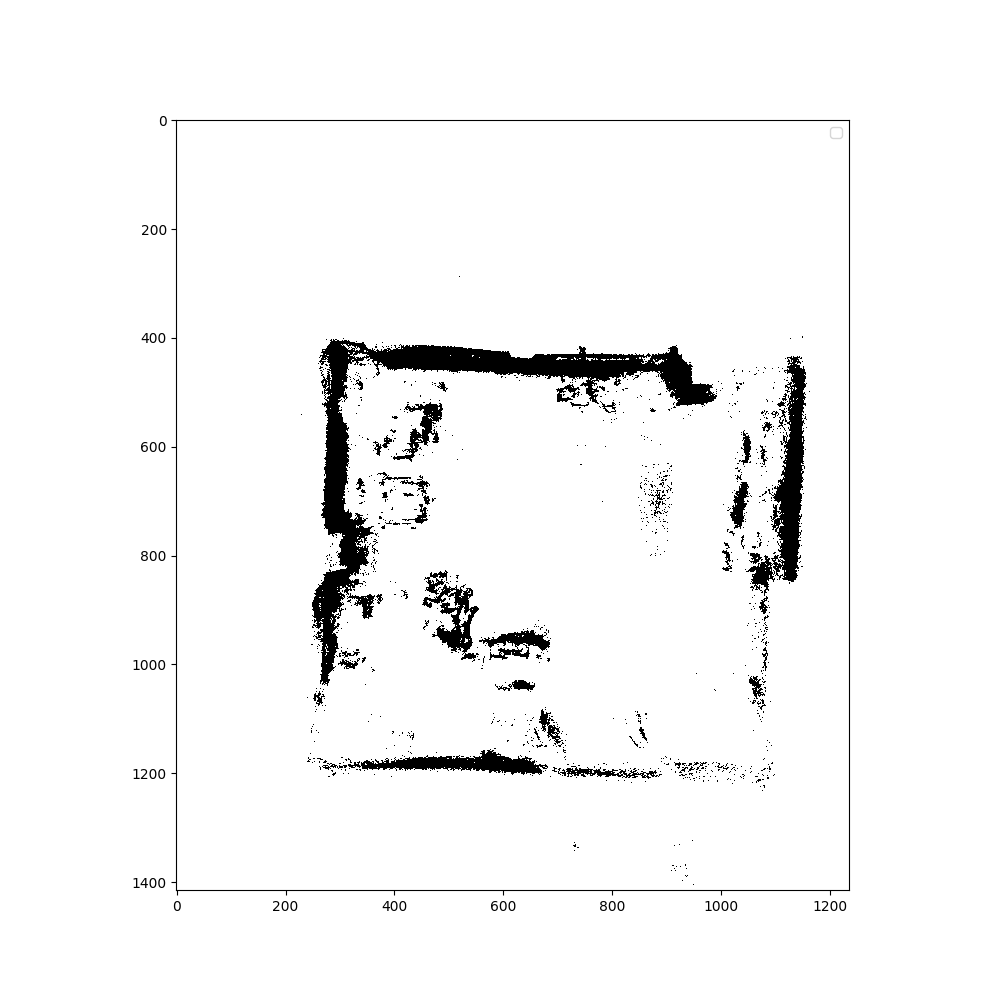

Coordinates: x=825, y=736 || formated: [736, 825]


In [16]:
from limp.planner.multi_level_planner import generate_obstacle_map
from limp.utils.fmt_utils import plot_map_with_points
%matplotlib widget

resolution = 0.01
h_min_bottom = -3
h_max_top = 1
obstacle_map, _, map_min_bound, map_max_bound = generate_obstacle_map(env_pointcloud, None, resolution, h_min_bottom,  h_max_top)

## Visually getting start point from map
clicked_points = plot_map_with_points(obstacle_map)

### Progressive motion planning

*************************************************
Starting Bi-level Planner
-------------------------------------------------
Obtaining predicate satisfying referent positions ...
-------------------------------------------------
Instruction predicates: ['near[green_plush_toy]', 'pick[green_plush_toy]', 'near[whiteboard::isinfrontof(green_plush_toy)]', 'release[green_plush_toy,whiteboard::isinfrontof(green_plush_toy)]'] 

Instruction predicate 1 of 4 
	Encoded Key: A || Predicate: near[green_plush_toy]                             || Predicate Action: near     || Arguments: green_plush_toy
	There are 1 element(s) with 'green_plush_toy' label
		Checking if any of these elements satisfy constraint: []
	Satisfying Elements: ['green_plush_toy_2c_1']
Instruction predicate 2 of 4 
	Encoded Key: B || Predicate: pick[green_plush_toy]                             || Predicate Action: pick     || Arguments: green_plush_toy
	There are 1 element(s) with 'green_plush_toy' label
		Checking if any of t

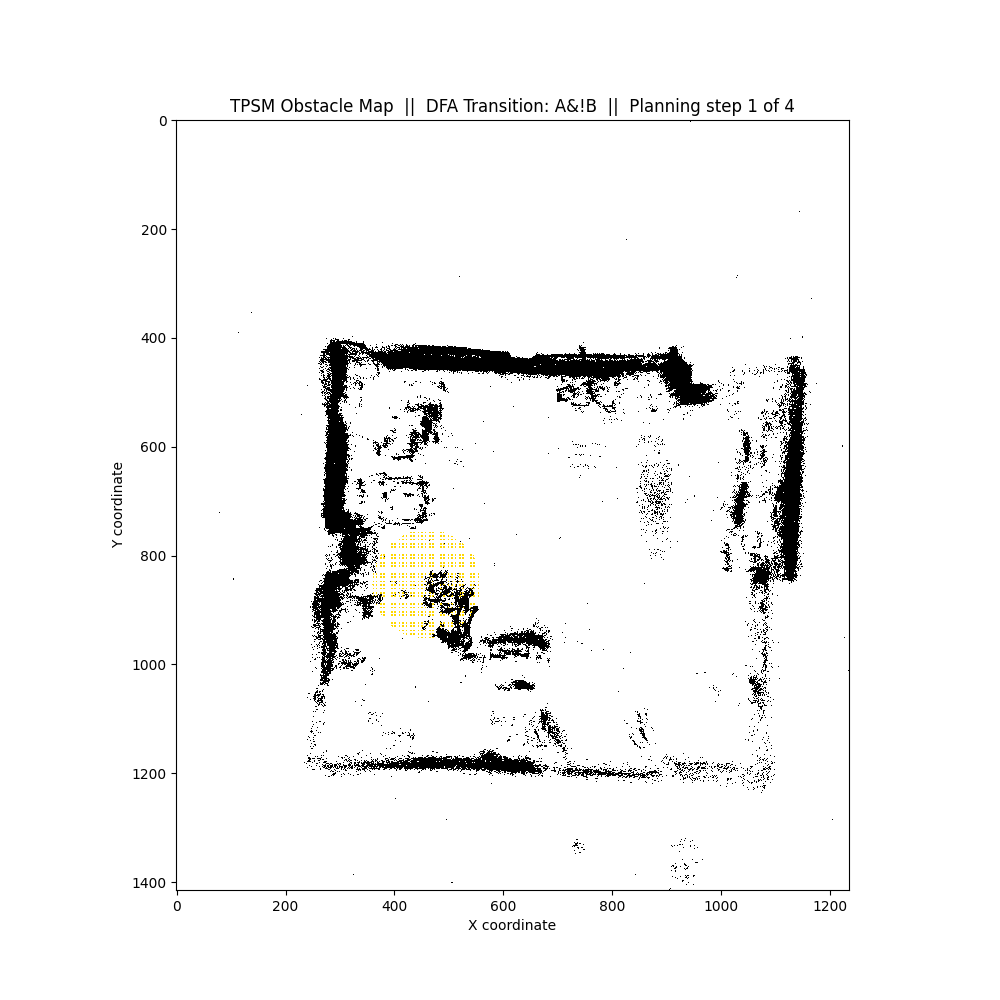

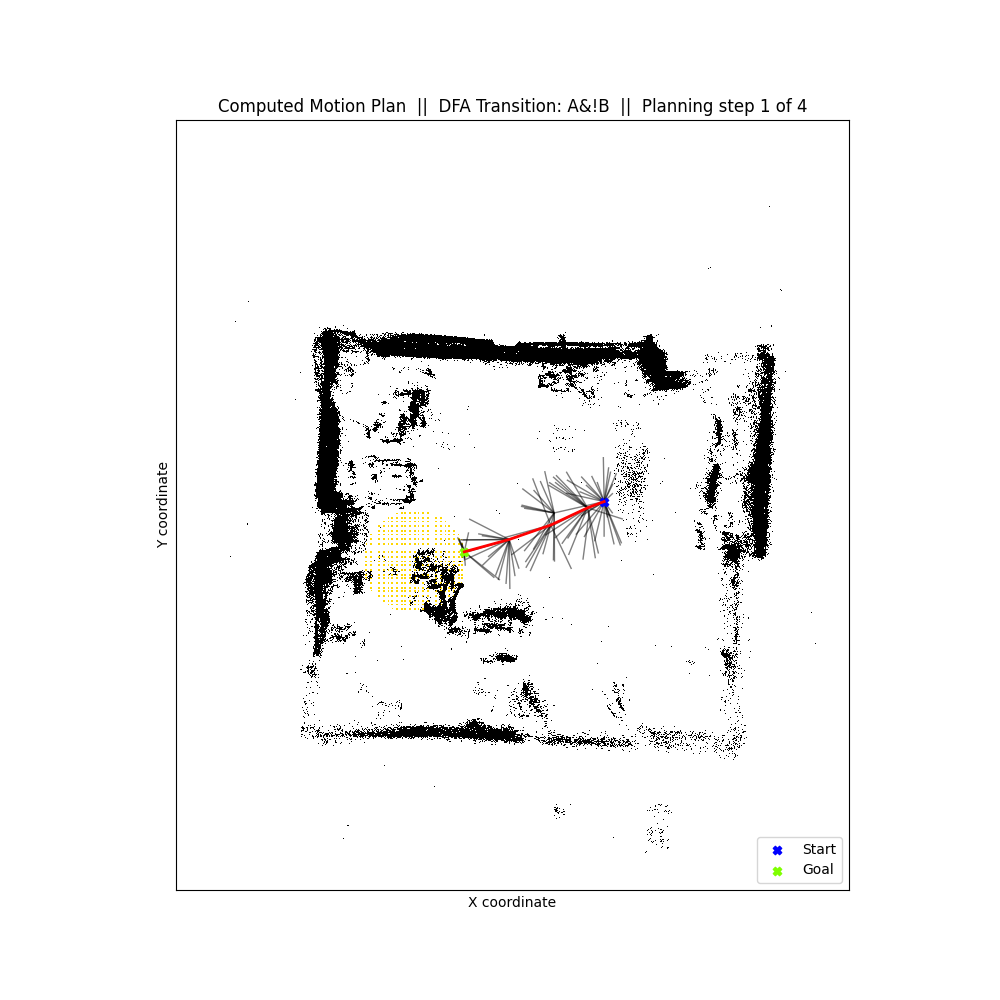

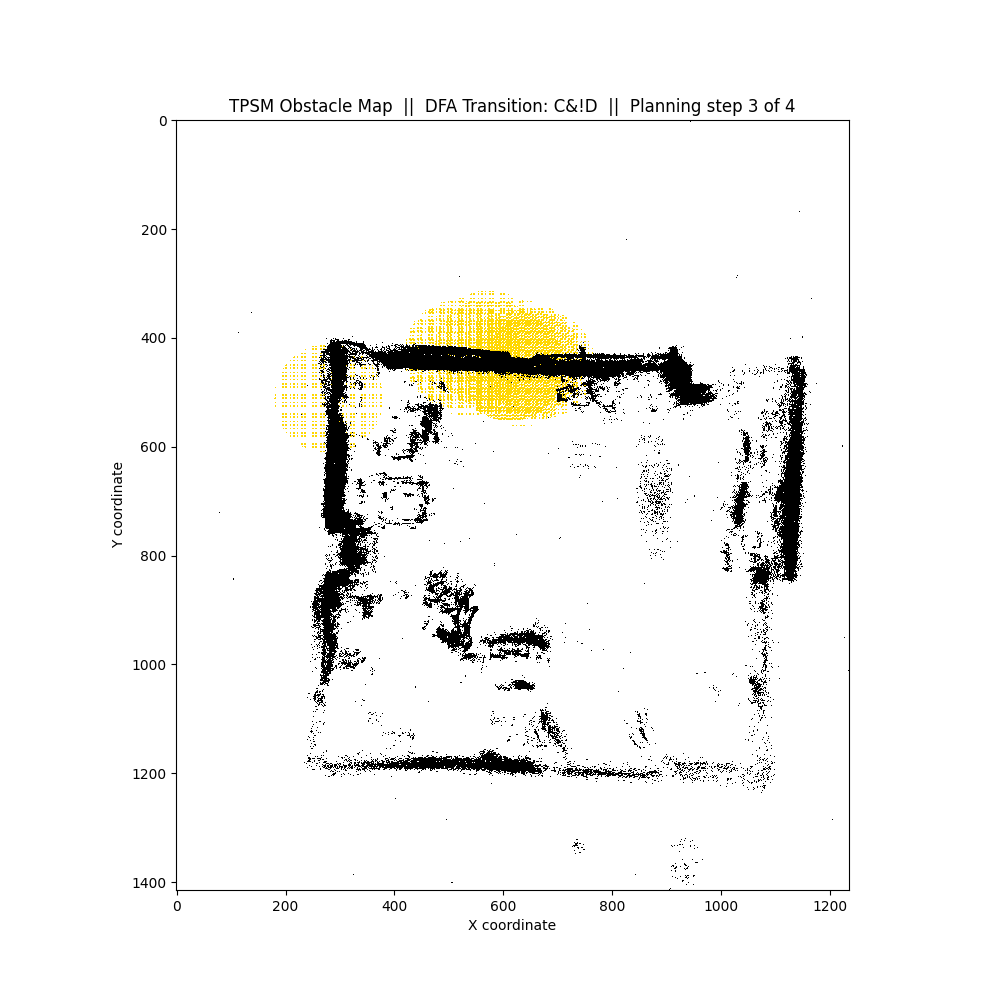

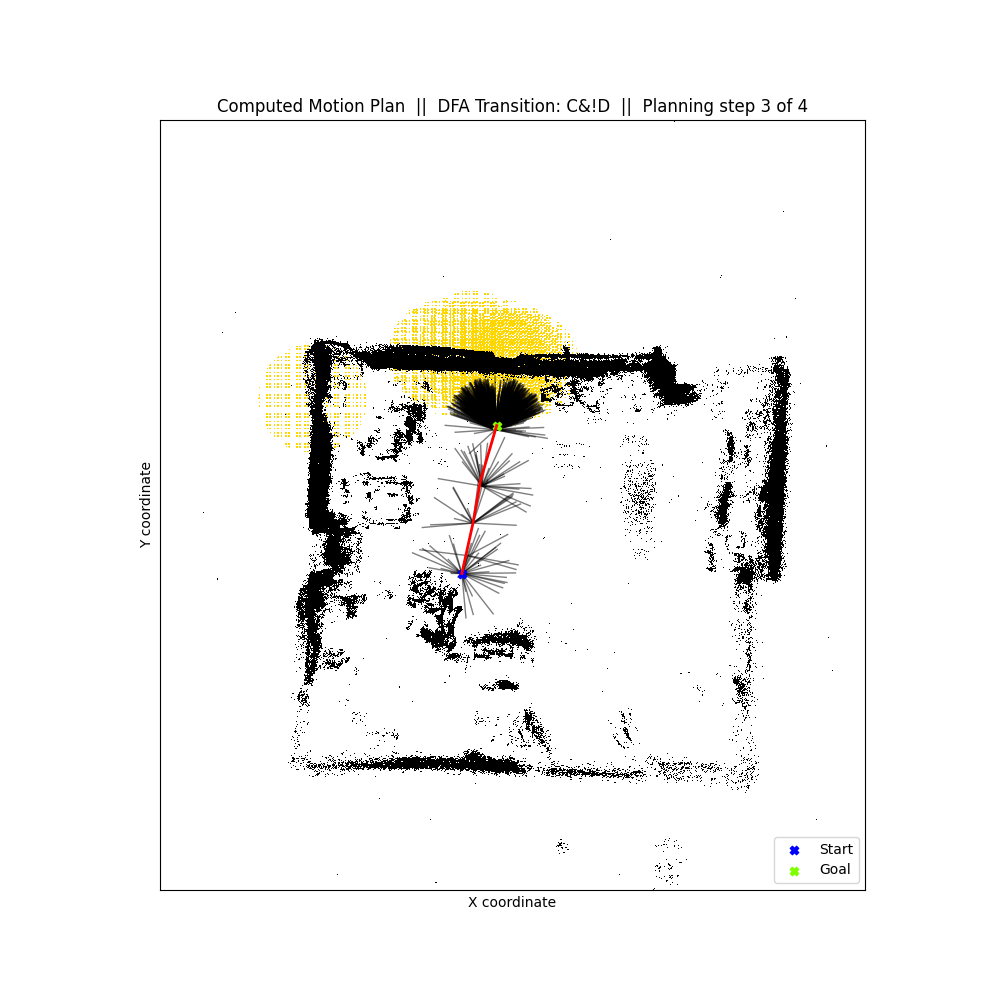

In [17]:
robot_motion_type = "2D"              #determines if planing space is 2D or 3D
z_height_2d=0                         #height of 2D planning space
      
step_factor=40                        #determines density of generated visual demarcations of regions of interest. Adjust for denser or sparser points
goal_sampling_percentage=15           #percentage of goal points to sample from the goal region to make exhaustive motion planning tractable
use_heuristic_flag=True               #determines if we use modified version of FMT* with cost to goal heuristic 
visualize_flag=True                   #determines if we visualize the computed motion plan
obstacle_map_resolution = 0.01        #determines the resolution of the obstacle map
filter_h_min_bottom = -3              #height to filter out pointcloud points below this height (meters) [Floor]      
filter_h_max_top= 1                   #height to filter out pointcloud points above this height (meters) [Roof] #see doors: 0.7 || Old value:-0.15
nearness_threshold = 1                #determines the meaning of nearness of planning space demarcation (meters)
start_point = clicked_points[-1]      #robot start location
show_color_bars_flag = False

computed_plan = progressive_motion_planner(start_point, task_dfa, dfa_graph, env_pointcloud, relevant_element_details, encoding_map, nearness_threshold, obstacle_map_resolution, filter_h_min_bottom, filter_h_max_top, robot_motion_type, height_2d=z_height_2d, stepfactor=step_factor, use_heuristic=use_heuristic_flag,visualize=visualize_flag,tmp_fldr=tmp_fldr,goal_sample_percentage=goal_sampling_percentage,show_color_bars=show_color_bars_flag)

### View Task and Motion Plan

In [18]:
computed_plan['world_plan'] 

{'step_1': {'action': 'navigation',
  'chosen_goal_referent': {'id': 'green_plush_toy_2c_1',
   'pos': array([ 3.51298404, -5.25042416, -0.14695237])},
  'path': array([[ 2.34201609, -1.60125637],
         [ 2.4621514 , -1.92125692],
         [ 2.79553954, -2.63297692],
         [ 3.07368255, -3.43440271],
         [ 3.31201609, -4.30125637]])},
 'step_2': {'action': 'pick',
  'chosen_goal_referent': {'id': 'green_plush_toy_2c_1',
   'pos': array([ 3.51298404, -5.25042416, -0.14695237])},
  'action_parameter': 'green_plush_toy',
  'action_parameter_positions': array([{'id': 'green_plush_toy_2c_1', 'pos': array([ 3.51298404, -5.25042416, -0.14695237])}],
        dtype=object)},
 'step_3': {'action': 'navigation',
  'chosen_goal_referent': {'id': 'whiteboard_3c_1',
   'pos': array([-0.38107281, -3.52880426, -0.63956636])},
  'path': array([[ 3.31201609, -4.30125637],
         [ 2.38480488, -4.0959646 ],
         [ 1.60205455, -3.95821418],
         [ 0.66720011, -3.6829901 ],
         [ 